In [48]:
from sklearn.datasets import load_breast_cancer, fetch_california_housing, load_iris
import pandas as pd

cancer = load_breast_cancer()
cancer_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
cancer_df['target'] = cancer.target
# cancer_df.to_csv('breast_cancer.csv', index=False)

housing = fetch_california_housing()
housing_df = pd.DataFrame(housing.data, columns=housing.feature_names)
housing_df['target'] = housing.target
# housing_df.to_csv('california_housing.csv', index=False)

iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target
# iris_df.to_csv('iris.csv', index=False)

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def calculate_correlation_matrix(dataset_name, df, target_col='target'):    
    features = df.drop(columns=[target_col], errors='ignore')
    
    correlation_matrix = features.corr()
    
    plt.figure(figsize=(15, 12))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                fmt=".2f", 
                cmap='coolwarm', 
                center=0,
                square=True,
                cbar_kws={"shrink": .8})
    plt.title(f'Corr Matrix of - {dataset_name}\n', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'correlation_heatmap_{dataset_name.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return correlation_matrix, features

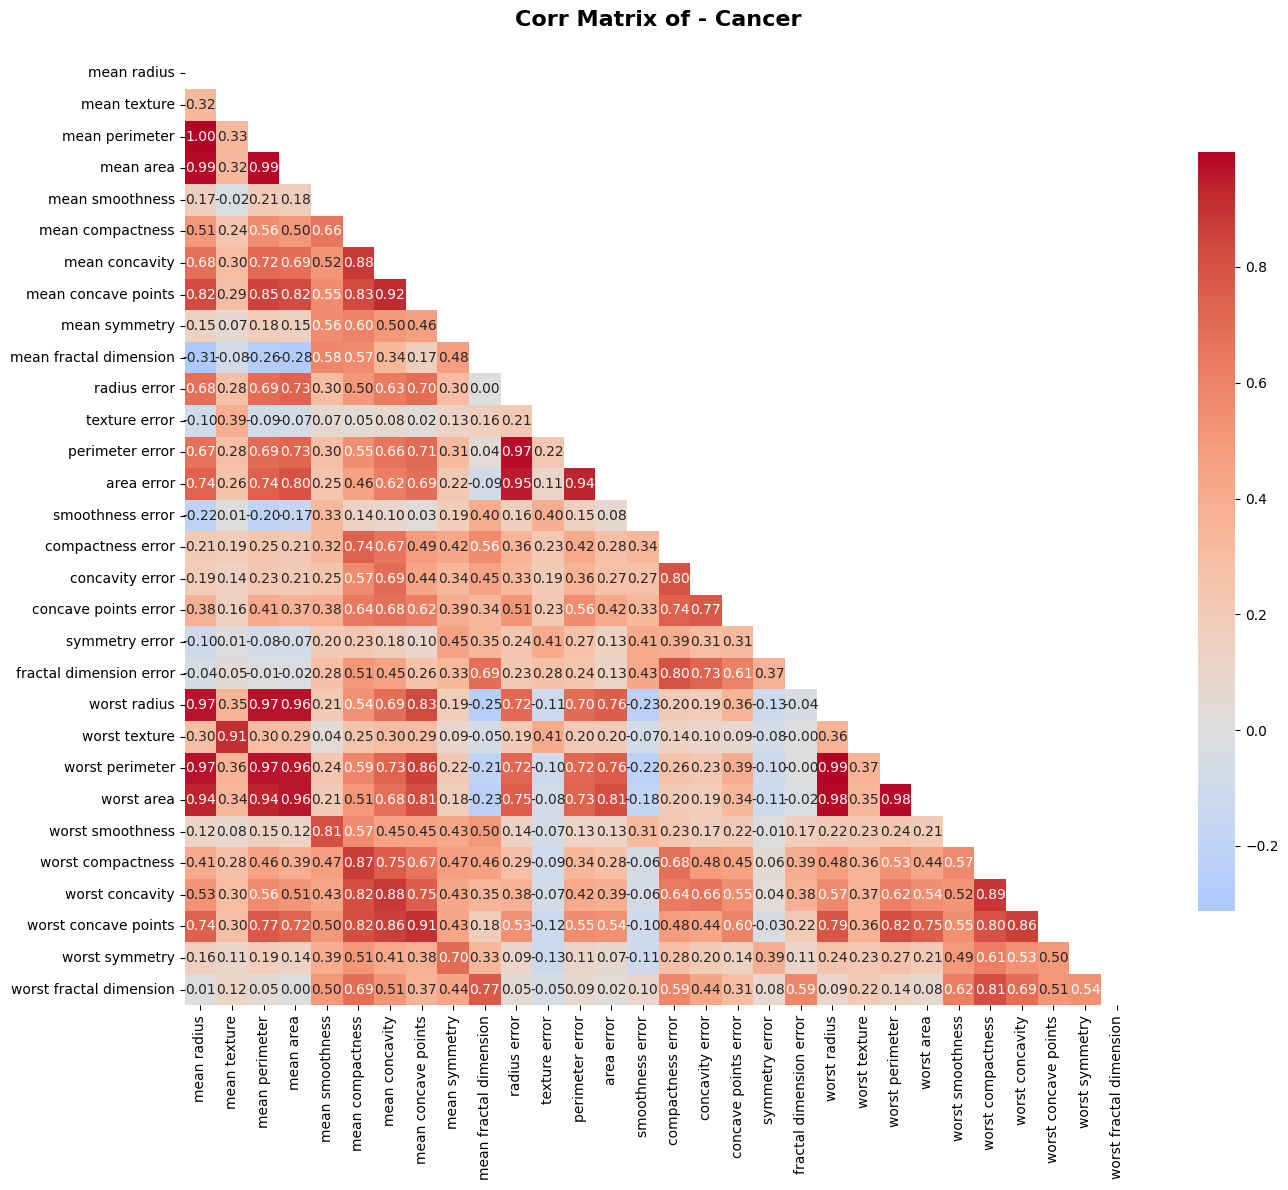

(                         mean radius  mean texture  mean perimeter  mean area  \
 mean radius                 1.000000      0.323782        0.997855   0.987357   
 mean texture                0.323782      1.000000        0.329533   0.321086   
 mean perimeter              0.997855      0.329533        1.000000   0.986507   
 mean area                   0.987357      0.321086        0.986507   1.000000   
 mean smoothness             0.170581     -0.023389        0.207278   0.177028   
 mean compactness            0.506124      0.236702        0.556936   0.498502   
 mean concavity              0.676764      0.302418        0.716136   0.685983   
 mean concave points         0.822529      0.293464        0.850977   0.823269   
 mean symmetry               0.147741      0.071401        0.183027   0.151293   
 mean fractal dimension     -0.311631     -0.076437       -0.261477  -0.283110   
 radius error                0.679090      0.275869        0.691765   0.732562   
 texture error  

In [50]:
calculate_correlation_matrix("Cancer", cancer_df)
# calculate_correlation_matrix("Housing", housing_df)
# calculate_correlation_matrix("Iris", iris_df)

In [51]:
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler

def apply_pca(X, variance_threshold=0.95):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    pca = PCA()
    pca.fit(X_scaled)
    
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
    
    pca_final = PCA(n_components=n_components)
    X_pca = pca_final.fit_transform(X_scaled)
    
    return X_pca, n_components, cumulative_variance

def apply_ica(X, n_components=None):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    if n_components is None:
        n_components = X.shape[1]
    
    ica = FastICA(n_components=n_components, random_state=42)
    X_ica = ica.fit_transform(X_scaled)
    
    return X_ica

def apply_svd(X, n_components=None):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    if n_components is None:
        n_components = min(X_scaled.shape)
    
    U, s, Vt = np.linalg.svd(X_scaled, full_matrices=False)
    
    explained_variance = (s ** 2) / np.sum(s ** 2)
    cumulative_variance = np.cumsum(explained_variance)
    
    X_svd = U[:, :n_components] * s[:n_components]
    
    return X_svd, n_components, cumulative_variance


cancer_df_drop_tar = cancer_df.drop('target', axis=1)
cancer_df__pca, n_pca, var_pca = apply_pca(cancer_df_drop_tar)
cancer_df__ica = apply_ica(cancer_df_drop_tar, n_components=n_pca)
cancer_df__svd, n_svd, var_svd = apply_svd(cancer_df_drop_tar, n_components=n_pca)

housing_df_drop_tar = housing_df.drop('target', axis=1)
housing_df__pca, n_pca, var_pca = apply_pca(housing_df_drop_tar)
housing_df__ica = apply_ica(housing_df_drop_tar, n_components=n_pca)
housing_df__svd, n_svd, var_svd = apply_svd(housing_df_drop_tar, n_components=n_pca)

iris_df_drop_tar = iris_df.drop('target', axis=1)
iris_df__pca, n_pca, var_pca = apply_pca(iris_df_drop_tar)
iris_df__ica = apply_ica(iris_df_drop_tar, n_components=n_pca)
iris_df__svd, n_svd, var_svd = apply_svd(iris_df_drop_tar, n_components=n_pca)

In [52]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score

def compare_methods(X_original, y, X_pca, X_ica, X_svd):
    scores = {}
    
    if len(np.unique(y)) <= 10:
        model = RandomForestClassifier(random_state=42)
        scoring = 'accuracy'
    else:
        model = RandomForestRegressor(random_state=42)
        scoring = 'r2'
    
    scores['Original'] = cross_val_score(model, X_original, y, cv=5, scoring=scoring).mean()
    scores['PCA'] = cross_val_score(model, X_pca, y, cv=5, scoring=scoring).mean()
    scores['ICA'] = cross_val_score(model, X_ica, y, cv=5, scoring=scoring).mean()
    scores['SVD'] = cross_val_score(model, X_svd, y, cv=5, scoring=scoring).mean()
    
    best_method = max(scores, key=scores.get)
    return best_method, scores

best_cancer, scores_cancer = compare_methods(
    cancer_df_drop_tar, cancer_df['target'], 
    cancer_df__pca, cancer_df__ica, cancer_df__svd
)

best_housing, scores_housing = compare_methods(
    housing_df_drop_tar, housing_df['target'],
    housing_df__pca, housing_df__ica, housing_df__svd
)

best_iris, scores_iris = compare_methods(
    iris_df_drop_tar, iris_df['target'],
    iris_df__pca, iris_df__ica, iris_df__svd
)

print(f"Breast Cancer - Best: {best_cancer}, Scores: {scores_cancer}")
print(f"California Housing - Best: {best_housing}, Scores: {scores_housing}")
print(f"Iris - Best: {best_iris}, Scores: {scores_iris}")

Breast Cancer - Best: Original, Scores: {'Original': np.float64(0.9560937742586555), 'PCA': np.float64(0.947259742276044), 'ICA': np.float64(0.9261605340785592), 'SVD': np.float64(0.9525073746312683)}
California Housing - Best: Original, Scores: {'Original': np.float64(0.6561187027256853), 'PCA': np.float64(0.5268604365953843), 'ICA': np.float64(0.5344552849363475), 'SVD': np.float64(0.5270556613883361)}
Iris - Best: Original, Scores: {'Original': np.float64(0.9666666666666668), 'PCA': np.float64(0.9066666666666666), 'ICA': np.float64(0.8933333333333333), 'SVD': np.float64(0.9066666666666666)}


In [53]:
from sklearn.feature_selection import SelectKBest, f_classif, f_regression, RFE
from sklearn.linear_model import LogisticRegression, LinearRegression

def apply_feature_selection(X, y, k=None):
    if k is None:
        k = X.shape[1] // 2
    
    if len(np.unique(y)) <= 10:
        selector_kbest = SelectKBest(score_func=f_classif, k=k)
        model_rfe = LogisticRegression(random_state=42, max_iter=1000)
    else:
        selector_kbest = SelectKBest(score_func=f_regression, k=k)
        model_rfe = LinearRegression()
    
    X_kbest = selector_kbest.fit_transform(X, y)
    
    rfe_selector = RFE(estimator=model_rfe, n_features_to_select=k)
    X_rfe = rfe_selector.fit_transform(X, y)
    
    return X_kbest, X_rfe

cancer_kbest, cancer_rfe = apply_feature_selection(cancer_df_drop_tar, cancer_df['target'])
housing_kbest, housing_rfe = apply_feature_selection(housing_df_drop_tar, housing_df['target'])
iris_kbest, iris_rfe = apply_feature_selection(iris_df_drop_tar, iris_df['target'])

print(f"Breast Cancer: {cancer_df_drop_tar.shape[1]} -> KBest:{cancer_kbest.shape[1]}, RFE:{cancer_rfe.shape[1]}")
print(f"California Housing: {housing_df_drop_tar.shape[1]} -> KBest:{housing_kbest.shape[1]}, RFE:{housing_rfe.shape[1]}")
print(f"Iris: {iris_df_drop_tar.shape[1]} -> KBest:{iris_kbest.shape[1]}, RFE:{iris_rfe.shape[1]}")

C:\Users\Reza\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Reza\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Breast Cancer: 30 -> KBest:15, RFE:15
California Housing: 8 -> KBest:4, RFE:4
Iris: 4 -> KBest:2, RFE:2


In [54]:
def compare_fs_methods(X_original, y, X_kbest, X_rfe):
    if len(np.unique(y)) <= 10:
        model = RandomForestClassifier(random_state=42)
        scoring = 'accuracy'
    else:
        model = RandomForestRegressor(random_state=42)
        scoring = 'r2'
    
    original_score = cross_val_score(model, X_original, y, cv=5, scoring=scoring).mean()
    kbest_score = cross_val_score(model, X_kbest, y, cv=5, scoring=scoring).mean()
    rfe_score = cross_val_score(model, X_rfe, y, cv=5, scoring=scoring).mean()
    
    best_method = 'KBest' if kbest_score > rfe_score else 'RFE'
    best_score = max(kbest_score, rfe_score)
    
    return best_method, best_score, original_score, kbest_score, rfe_score

best_cancer, score_cancer, orig_cancer, kbest_cancer, rfe_cancer = compare_fs_methods(
    cancer_df_drop_tar, cancer_df['target'], cancer_kbest, cancer_rfe
)

best_housing, score_housing, orig_housing, kbest_housing, rfe_housing = compare_fs_methods(
    housing_df_drop_tar, housing_df['target'], housing_kbest, housing_rfe
)

best_iris, score_iris, orig_iris, kbest_iris, rfe_iris = compare_fs_methods(
    iris_df_drop_tar, iris_df['target'], iris_kbest, iris_rfe
)

print(f"Breast Cancer - Best: {best_cancer}, KBest: {kbest_cancer:.4f}, RFE: {rfe_cancer:.4f}, Original: {orig_cancer:.4f}")
print(f"California Housing - Best: {best_housing}, KBest: {kbest_housing:.4f}, RFE: {rfe_housing:.4f}, Original: {orig_housing:.4f}")
print(f"Iris - Best: {best_iris}, KBest: {kbest_iris:.4f}, RFE: {rfe_iris:.4f}, Original: {orig_iris:.4f}")

Breast Cancer - Best: RFE, KBest: 0.9438, RFE: 0.9578, Original: 0.9561
California Housing - Best: RFE, KBest: 0.3735, RFE: 0.5321, Original: 0.6561
Iris - Best: RFE, KBest: 0.9667, RFE: 0.9667, Original: 0.9667


In [55]:
# So we have these:
# cancer_df 
# cancer_rfe
# cancer_df__pca

# housing_df
# housing_rfe
# housing_df__pca

# iris_df
# iris_kbest
# iris_df__pca

In [56]:
def compare_regression_models(X_original, X_pca, X_fs, y):
    original_model = LinearRegression()
    pca_model = LinearRegression()
    fs_model = LinearRegression()

    original_coef = original_model.fit(X_original, y).coef_
    pca_coef = pca_model.fit(X_pca, y).coef_
    fs_coef = fs_model.fit(X_fs, y).coef_

    original_score = cross_val_score(LinearRegression(), X_original, y, cv=5, scoring='r2').mean()
    pca_score = cross_val_score(LinearRegression(), X_pca, y, cv=5, scoring='r2').mean()
    fs_score = cross_val_score(LinearRegression(), X_fs, y, cv=5, scoring='r2').mean()

    return {
        'original_coef': original_coef,
        'pca_coef': pca_coef,
        'fs_coef': fs_coef,
        'original_score': original_score,
        'pca_score': pca_score,
        'fs_score': fs_score,
        'coef_std_original': np.std(original_coef),
        'coef_std_pca': np.std(pca_coef),
        'coef_std_fs': np.std(fs_coef),
        'coef_range_original': np.ptp(original_coef),
        'coef_range_pca': np.ptp(pca_coef),
        'coef_range_fs': np.ptp(fs_coef)
    }

housing_results = compare_regression_models(
    housing_df_drop_tar,
    housing_df__pca,
    housing_rfe,
    housing_df['target']
)

print("California Housing Results:")
print(f"R2 Scores - Original: {housing_results['original_score']:.4f}, PCA: {housing_results['pca_score']:.4f}, FS: {housing_results['fs_score']:.4f}")
print(f"Coefficient STD - Original: {housing_results['coef_std_original']:.4f}, PCA: {housing_results['coef_std_pca']:.4f}, FS: {housing_results['coef_std_fs']:.4f}")
print(f"Coefficient Range - Original: {housing_results['coef_range_original']:.4f}, PCA: {housing_results['coef_range_pca']:.4f}, FS: {housing_results['coef_range_fs']:.4f}")
print("\nOriginal Coefficients:", housing_results['original_coef'])
print("PCA Coefficients:", housing_results['pca_coef'])
print("FS Coefficients:", housing_results['fs_coef'])


California Housing Results:
R2 Scores - Original: 0.5530, PCA: 0.4316, FS: 0.5341
Coefficient STD - Original: 0.3505, PCA: 0.3331, FS: 0.3958
Coefficient Range - Original: 1.0796, PCA: 1.0615, FS: 0.8865

Original Coefficients: [ 4.36693293e-01  9.43577803e-03 -1.07322041e-01  6.45065694e-01
 -3.97638942e-06 -3.78654265e-03 -4.21314378e-01 -4.34513755e-01]
PCA Coefficients: [ 0.02815106  0.13630222  0.03983107 -0.74137041  0.0038712   0.32016506]
FS Coefficients: [ 0.36686091  0.16556978 -0.50511486 -0.5196499 ]


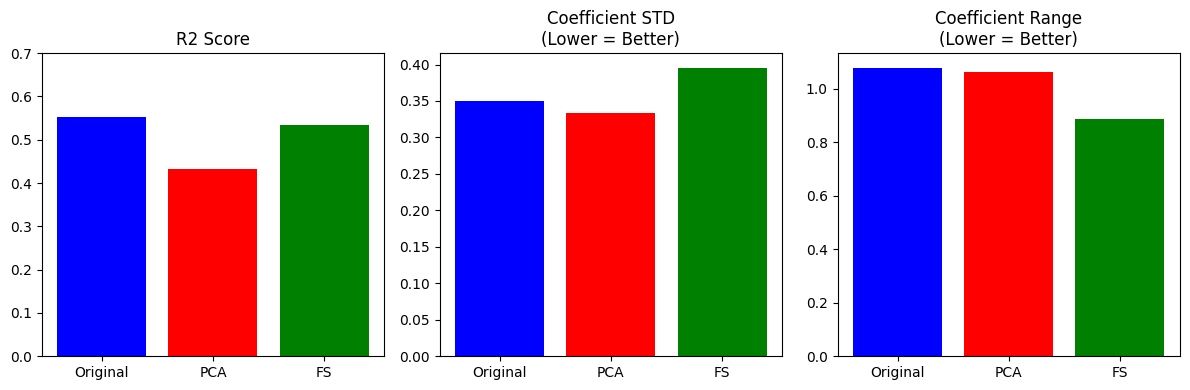

In [57]:
methods = ['Original', 'PCA', 'FS']
scores = [0.5530, 0.4316, 0.5341]
stds = [0.3505, 0.3331, 0.3958]
ranges = [1.0796, 1.0615, 0.8865]

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.bar(methods, scores, color=['blue', 'red', 'green'])
plt.title('R2 Score')
plt.ylim(0, 0.7)

plt.subplot(1, 3, 2)
plt.bar(methods, stds, color=['blue', 'red', 'green'])
plt.title('Coefficient STD\n(Lower = Better)')

plt.subplot(1, 3, 3)
plt.bar(methods, ranges, color=['blue', 'red', 'green'])
plt.title('Coefficient Range\n(Lower = Better)')

plt.tight_layout()
plt.savefig('regression_comparison.png')
plt.show()

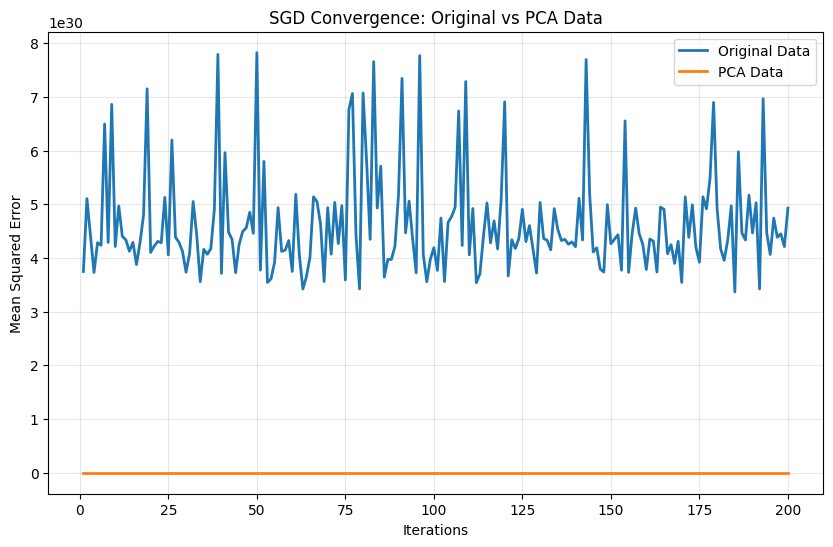

Final Error - Original: 4930235351974655250786114600960.0000
Final Error - PCA: 9062760188604317696000.0000


In [65]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

def compare_sgd_convergence(X_original, X_pca, y, max_iter=25, eta0=1e-3):
    # scaler_orig = StandardScaler()
    # scaler_pca = StandardScaler()

    # X_orig_scaled = scaler_orig.fit_transform(X_original)
    # X_pca_scaled = scaler_pca.fit_transform(X_pca)

    sgd_orig = SGDRegressor(max_iter=1, tol=None, warm_start=True,
                            learning_rate='constant', eta0=eta0, random_state=42)
    sgd_pca = SGDRegressor(max_iter=1, tol=None, warm_start=True,
                           learning_rate='constant', eta0=eta0, random_state=42)

    errors_orig = []
    errors_pca = []

    for i in range(max_iter):
        sgd_orig.fit(X_original, y)
        sgd_pca.fit(X_pca, y)

        e_orig = mean_squared_error(y, sgd_orig.predict(X_original))
        e_pca = mean_squared_error(y, sgd_pca.predict(X_pca))

        errors_orig.append(e_orig)
        errors_pca.append(e_pca)

    return errors_orig, errors_pca

errors_orig, errors_pca = compare_sgd_convergence(housing_df_drop_tar, housing_df__pca, housing_df['target'],
                                                  max_iter=200, eta0=1e-3)

plt.figure(figsize=(10,6))
plt.plot(range(1, len(errors_orig)+1), errors_orig, label='Original Data', linewidth=2)
plt.plot(range(1, len(errors_pca)+1), errors_pca, label='PCA Data', linewidth=2)
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error')
plt.title('SGD Convergence: Original vs PCA Data')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Final Error - Original: {errors_orig[-1]:.4f}")
print(f"Final Error - PCA: {errors_pca[-1]:.4f}")


In [59]:
X_pca = housing_df__pca
X_orig = housing_df_drop_tar
y = housing_df['target']

print("shapes:", X_orig.shape, X_pca.shape, y.shape)
print("any NaN in PCA?", np.isnan(X_pca.values).any() if hasattr(X_pca,'values') else np.isnan(X_pca).any())
print("allclose to zero (PCA)?", np.allclose(X_pca, 0))
print("PCA col means:", np.mean(X_pca, axis=0))
print("PCA col stds:", np.std(X_pca, axis=0))
print("PCA var sum:", np.var(X_pca, axis=0).sum())
print("y mean/std:", np.mean(y), np.std(y))


shapes: (20640, 8) (20640, 6) (20640,)
any NaN in PCA? False
allclose to zero (PCA)? False
PCA col means: [-1.01630590e-15  6.16275979e-16  4.50931282e-16  6.98300160e-17
  6.09493076e-17  1.66533454e-17]
PCA col stds: [1.42370974 1.37160475 1.12742661 1.01540026 1.00152664 0.81202219]
PCA var sum: 7.872813090278473
y mean/std: 2.068558169089147 1.1539282040412253


In [60]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import time

def compare_kmeans(X_original, X_pca, n_clusters=3):
    results = {}
    
    start_time = time.time()
    kmeans_orig = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels_orig = kmeans_orig.fit_predict(X_original)
    time_orig = time.time() - start_time
    
    start_time = time.time()
    kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels_pca = kmeans_pca.fit_predict(X_pca)
    time_pca = time.time() - start_time
    
    inertia_orig = kmeans_orig.inertia_
    silhouette_orig = silhouette_score(X_original, labels_orig)

    inertia_pca = kmeans_pca.inertia_
    silhouette_pca = silhouette_score(X_pca, labels_pca)
    
    results['Original'] = {
        'inertia': inertia_orig,
        'silhouette': silhouette_orig,
        'time': time_orig,
        'iterations': kmeans_orig.n_iter_,
        'labels': labels_orig
    }
    
    results['PCA'] = {
        'inertia': inertia_pca,
        'silhouette': silhouette_pca,
        'time': time_pca,
        'iterations': kmeans_pca.n_iter_,
        'labels': labels_pca
    }
    
    return results

iris_results = compare_kmeans(iris_df_drop_tar, iris_df__pca, n_clusters=3)

print("Iris Clustering Results:")
print(f"Original - Inertia: {iris_results['Original']['inertia']:.2f}, Silhouette: {iris_results['Original']['silhouette']:.3f}, Time: {iris_results['Original']['time']:.3f}s, Iterations: {iris_results['Original']['iterations']}")
print(f"PCA - Inertia: {iris_results['PCA']['inertia']:.2f}, Silhouette: {iris_results['PCA']['silhouette']:.3f}, Time: {iris_results['PCA']['time']:.3f}s, Iterations: {iris_results['PCA']['iterations']}")

Iris Clustering Results:
Original - Inertia: 78.85, Silhouette: 0.553, Time: 0.177s, Iterations: 4
PCA - Inertia: 115.02, Silhouette: 0.509, Time: 0.041s, Iterations: 4


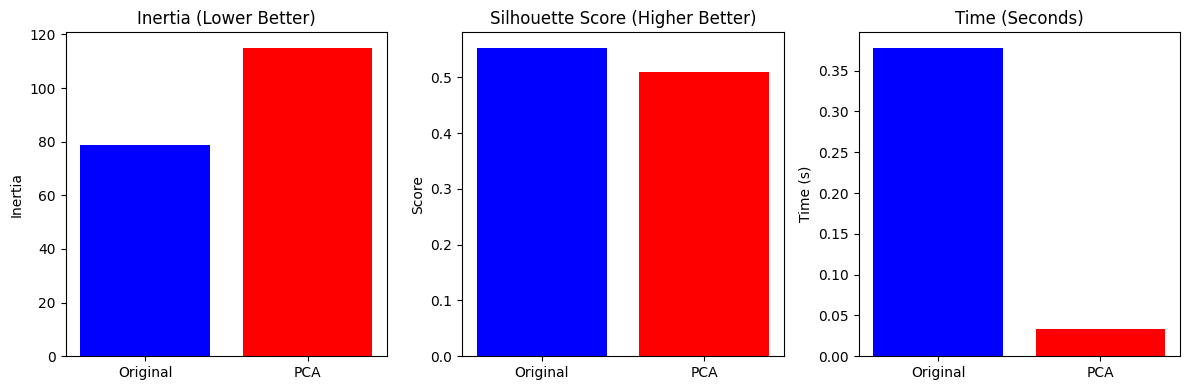

In [62]:
methods = ['Original', 'PCA']
inertia = [78.85, 115.02]
silhouette = [0.553, 0.509]
times = [0.378, 0.033]

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.bar(methods, inertia, color=['blue', 'red'])
plt.title('Inertia (Lower Better)')
plt.ylabel('Inertia')

plt.subplot(1, 3, 2)
plt.bar(methods, silhouette, color=['blue', 'red'])
plt.title('Silhouette Score (Higher Better)')
plt.ylabel('Score')

plt.subplot(1, 3, 3)
plt.bar(methods, times, color=['blue', 'red'])
plt.title('Time (Seconds)')
plt.ylabel('Time (s)')

plt.tight_layout()
plt.savefig('kmeans_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [63]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def compare_knn(X_original, X_pca, y, test_size=0.2):
    from sklearn.model_selection import train_test_split
    
    X_orig_train, X_orig_test, y_train, y_test = train_test_split(
        X_original, y, test_size=test_size, random_state=42, stratify=y
    )
    
    X_pca_train, X_pca_test, y_train_pca, y_test_pca = train_test_split(
        X_pca, y, test_size=test_size, random_state=42, stratify=y
    )
    
    results = {}
    
    knn_orig = KNeighborsClassifier(n_neighbors=5)
    
    start_fit = time.time()
    knn_orig.fit(X_orig_train, y_train)
    fit_time_orig = time.time() - start_fit
    
    start_predict = time.time()
    y_pred_orig = knn_orig.predict(X_orig_test)
    predict_time_orig = time.time() - start_predict
    
    accuracy_orig = accuracy_score(y_test, y_pred_orig)
    
    knn_pca = KNeighborsClassifier(n_neighbors=5)
    
    start_fit = time.time()
    knn_pca.fit(X_pca_train, y_train_pca)
    fit_time_pca = time.time() - start_fit
    
    start_predict = time.time()
    y_pred_pca = knn_pca.predict(X_pca_test)
    predict_time_pca = time.time() - start_predict
    
    accuracy_pca = accuracy_score(y_test_pca, y_pred_pca)
    
    results['Original'] = {
        'accuracy': accuracy_orig,
        'fit_time': fit_time_orig,
        'predict_time': predict_time_orig,
        'total_time': fit_time_orig + predict_time_orig
    }
    
    results['PCA'] = {
        'accuracy': accuracy_pca,
        'fit_time': fit_time_pca,
        'predict_time': predict_time_pca,
        'total_time': fit_time_pca + predict_time_pca
    }
    
    return results

knn_cancer_results = compare_knn(cancer_df_drop_tar, cancer_df__pca, cancer_df['target'])

print("KNN - Breast Cancer Results:")
print(f"Original - Accuracy: {knn_cancer_results['Original']['accuracy']:.3f}, Fit Time: {knn_cancer_results['Original']['fit_time']:.3f}s, Predict Time: {knn_cancer_results['Original']['predict_time']:.3f}s")
print(f"PCA - Accuracy: {knn_cancer_results['PCA']['accuracy']:.3f}, Fit Time: {knn_cancer_results['PCA']['fit_time']:.3f}s, Predict Time: {knn_cancer_results['PCA']['predict_time']:.3f}s")

KNN - Breast Cancer Results:
Original - Accuracy: 0.912, Fit Time: 0.006s, Predict Time: 0.047s
PCA - Accuracy: 0.956, Fit Time: 0.003s, Predict Time: 0.012s


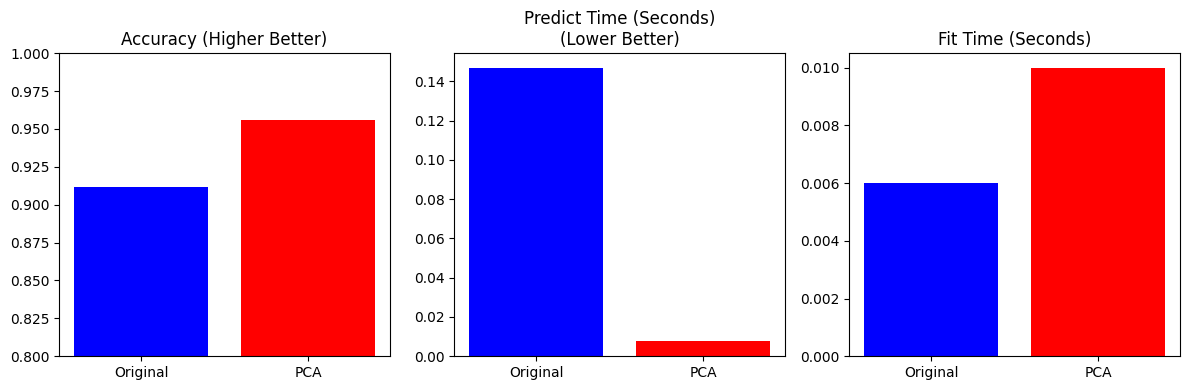

In [ ]:
methods = ['Original', 'PCA']
accuracy = [0.912, 0.956]
predict_time = [0.147, 0.008]
fit_time = [0.006, 0.010]

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.bar(methods, accuracy, color=['blue', 'red'])
plt.title('Accuracy (Higher Better)')
plt.ylim(0.8, 1.0)

plt.subplot(1, 3, 2)
plt.bar(methods, predict_time, color=['blue', 'red'])
plt.title('Predict Time (Seconds)\n(Lower Better)')

plt.subplot(1, 3, 3)
plt.bar(methods, fit_time, color=['blue', 'red'])
plt.title('Fit Time (Seconds)')

plt.tight_layout()
plt.savefig('knn_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def compare_random_forest(X_original, X_pca, X_fs, y, test_size=0.2):
    X_orig_train, X_orig_test, y_train, y_test = train_test_split(
        X_original, y, test_size=test_size, random_state=42, stratify=y
    )
    
    X_pca_train, X_pca_test, _, _ = train_test_split(
        X_pca, y, test_size=test_size, random_state=42, stratify=y
    )
    
    X_fs_train, X_fs_test, _, _ = train_test_split(
        X_fs, y, test_size=test_size, random_state=42, stratify=y
    )
    
    results = {}
    
    start_time = time.time()
    rf_orig = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_orig.fit(X_orig_train, y_train)
    fit_time_orig = time.time() - start_time
    
    y_pred_orig = rf_orig.predict(X_orig_test)
    accuracy_orig = accuracy_score(y_test, y_pred_orig)
    
    start_time = time.time()
    rf_pca = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_pca.fit(X_pca_train, y_train)
    fit_time_pca = time.time() - start_time
    
    y_pred_pca = rf_pca.predict(X_pca_test)
    accuracy_pca = accuracy_score(y_test, y_pred_pca)
    
    start_time = time.time()
    rf_fs = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_fs.fit(X_fs_train, y_train)
    fit_time_fs = time.time() - start_time
    
    y_pred_fs = rf_fs.predict(X_fs_test)
    accuracy_fs = accuracy_score(y_test, y_pred_fs)
    
    results['Original'] = {'accuracy': accuracy_orig, 'fit_time': fit_time_orig}
    results['PCA'] = {'accuracy': accuracy_pca, 'fit_time': fit_time_pca}
    results['FS'] = {'accuracy': accuracy_fs, 'fit_time': fit_time_fs}
    
    return results

rf_cancer_results = compare_random_forest(
    cancer_df_drop_tar, 
    cancer_df__pca, 
    cancer_rfe,
    cancer_df['target']
)

print("Random Forest - Breast Cancer Results:")
print(f"Original - Accuracy: {rf_cancer_results['Original']['accuracy']:.3f}, Time: {rf_cancer_results['Original']['fit_time']:.3f}s")
print(f"PCA - Accuracy: {rf_cancer_results['PCA']['accuracy']:.3f}, Time: {rf_cancer_results['PCA']['fit_time']:.3f}s")
print(f"FS - Accuracy: {rf_cancer_results['FS']['accuracy']:.3f}, Time: {rf_cancer_results['FS']['fit_time']:.3f}s")

Random Forest - Breast Cancer Results:
Original - Accuracy: 0.956, Time: 0.184s
PCA - Accuracy: 0.912, Time: 0.140s
FS - Accuracy: 0.947, Time: 0.114s


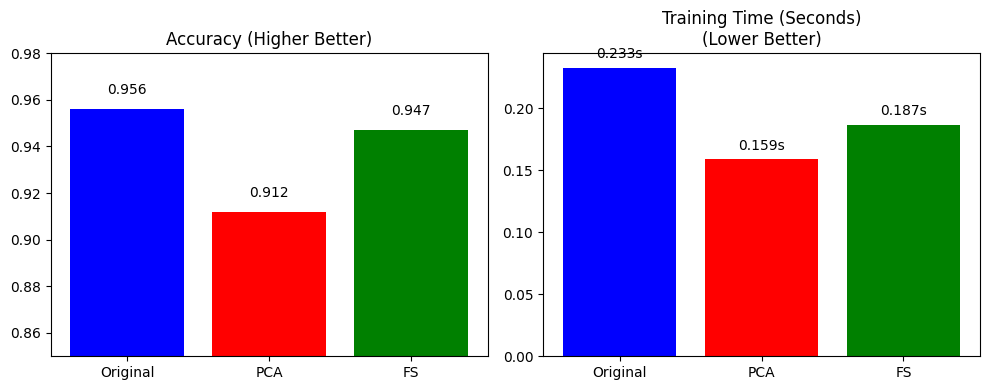

In [ ]:
methods = ['Original', 'PCA', 'FS']
accuracy = [0.956, 0.912, 0.947]
times = [0.233, 0.159, 0.187]

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
bars1 = plt.bar(methods, accuracy, color=['blue', 'red', 'green'])
plt.title('Accuracy (Higher Better)')
plt.ylim(0.85, 0.98)
for bar, acc in zip(bars1, accuracy):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, f'{acc:.3f}', 
             ha='center', va='bottom')

plt.subplot(1, 2, 2)
bars2 = plt.bar(methods, times, color=['blue', 'red', 'green'])
plt.title('Training Time (Seconds)\n(Lower Better)')
for bar, t in zip(bars2, times):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, f'{t:.3f}s', 
             ha='center', va='bottom')

plt.tight_layout()
plt.show()